# Нейронные сети классификации изображений

# 4 Разветвленные сети, GoogLeNet

Вообще стоит задуматься, какая же свертка лучше?

Исследователи используют совершенно различные свертки и маленькие с ядром $1 \times 1$ и большие с ядром $11 \times 11$. Нельзя утверждать что какое-либо из них лучше или хуже другого. Как же выбрать?

Ответ прост - не выбирать вовсе.

Если мы допускаем, что разные ядра могут быть полезны, так давайте их использовать вместе, и пусть уже процесс обучения решает, какие полезны, какие нет.

Мы можем одновременно, к одним и тем же входным массивам применять параллельно различные свертки (или комбинации сверток), а затем объединить результаты.

Такие идеи заложены в сетях Inception и GoogleNet.

Такие сети состоят из блоков **параллельно** работающих сверток и других слоев.

## Блоки Inception

Блок Inception, см. рис., принимает входной тензор и применяет к нему одновременно сразу несколько разных сверток, результаты которых объединяются (контактенируются).

![img](https://d2l.ai/_images/inception.svg)

Здесь есть свертки с ядром $1\times 1$. *Ветви* из нескольких подряд сверток $1\times 1$, $3\times 3$, или $5\times 5$. И даже субдискретизация с ядром $3\times 3$ с последующей сверткой $1\times 1$. При необходимости используется набивка, чтобы пространственные размеры выхода не поменялись. По своему желанию можете добавить сюда еще вариантов сверток. Число фильтров задается.


Реализуем такой блок. Теперь архитектура разветвленная, контейнер Sequential не подойдет. Вместо этого мы создадим свой класс Inception для блока унаследовав от класса tf.keras.Model. Пропишем параметры блока и функции для инициализации `__init__` и расчета выхода `call` блока.   

In [1]:
# установим вспомогательные функции из курса  d2l
!pip -q install d2l==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l # вспомогательные функции для данных, обучения и отображения

# Класс для блока Inception
class Inception(tf.keras.Model): # наследник от tf.keras.Model
    # аргументы `c1`--`c4`  - число фильтров каждой ветви блока

    # задаем параметры и инициализируем.
    def __init__(self, c1, c2, c3, c4):
        super().__init__() # инициализируем родителя
        # Ветвь 1 одна свертка с ядром 1 x 1, пространственные размеры не меняются, набивка не нужна.
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')

        # Ветвь 2 свертка с ядром 1 x 1 и последующая свертка с ядром 3 x 3
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu') # пространственные размеры не меняются, набивка не нужна
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same', # пространственные размеры меняются, набивка нужна
                                           activation='relu')

        # Ветвь 3 свертка с ядром 1 x 1 и последующая свертка с ядром 5 x 5
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu') # пространственные размеры не меняются, набивка не нужна
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same', # пространственные размеры меняются, набивка нужна
                                           activation='relu')

        # Ветвь 4  maximum pooling c ядром 3 x 3  и последующей сверткой с ядром 1 x 1
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same') # пространственные размеры меняются, набивка нужна
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu') # пространственные размеры не меняются, набивка не нужна

    # рассчитываем выход блока
    def call(self, x):
        p1 = self.p1_1(x) # выход первой ветви
        p2 = self.p2_2(self.p2_1(x)) # выход второй ветви
        p3 = self.p3_2(self.p3_1(x)) # выход третьей ветви
        p4 = self.p4_2(self.p4_1(x)) # выход четвертой ветви
        # Объединяем все выходы по каналам
        return tf.keras.layers.Concatenate()([p1, p2, p3, p4]) # возвращаем

Разные ядра будут строить различные признаки изображения, скорей всего найдутся среди них хорошие.




## Сеть GoogLeNet

Сеть  состоит из ряда сверточных слоев, слоев субдискретизации и 9 блоков слоев Inception, между блоками используют субдискретизацию Maximum pooling, после последнего блока используют global average pooling и наконец последний полносвязный слой классификации, с числом нейронов определяемых числом классов.

![img](https://d2l.ai/_images/inception-full-90.svg)


Будем создавать такую сеть шаг за шагом.

Первая часть, назовем ее b1, состоит из 64-канальных сверток с ядром $7\times 7$, сдвиг 2, набивка  и слоя MaxPool с ядром $3\times 3$ со сдвигом 2, с набивкой.


In [3]:
# Часть 1, начало сети
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

Вторая часть b2 состоит из двух сверточных слоев,
первый 64-канальный с ядром $1\times 1$, второй 3*64-канальный с ядром $3\times 3$ и слоя MaxPool.


In [4]:
# Часть 2
def b2():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation='relu'),
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

Третья часть содержит два подряд идущих блока Inception и слой пулинга. Хоть сами блоки имеют разветвленную архитектуру, но соединяются они последовательно, значит можем использовать контейнер Sequential.

В первом блоке $64+128+32+32=256$ каналов, во втором  $128+192+96+64=480$.


In [5]:
# Часть 3
def b3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

В четвертой части аж 5 подряд идущих блока Inception и слой пулинга. Число каналов: $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
и $256+320+128+128=832$ соответственно.



In [6]:
# Часть 4
def b4():
    return tf.keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

Наконец, часть 5 содержит два Inception блока с числом каналов $256+320+128+128=832$ и $384+384+128+128=1024$,  слой global average pooling (как в NiN) и полносвязный слой с 10 нейронами.

Вся сеть это последовательное подключение ее частей.


In [7]:
# Часть 5
def b5():
    return tf.keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Flatten()
    ])

# Вся сеть
def net():
    return tf.keras.Sequential([b1(), b2(), b3(), b4(), b5(),
                                tf.keras.layers.Dense(10)])

Для Fashion-MNIST GoogLeNet слишком большая, уменьшим размер изображений с 224 до 96.

Посмотрим на размеры выходов разных частей.


In [8]:
X = tf.random.uniform(shape=(1, 96, 96, 3))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


In [9]:
input_shape=(None,224, 224, 3)
nn=net()
nn.build(input_shape)
nn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 56, 56, 64)        9472      
                                                                 
 sequential_7 (Sequential)   (None, 28, 28, 192)       114944    
                                                                 
 sequential_8 (Sequential)   (None, 14, 14, 480)       552432    
                                                                 
 sequential_9 (Sequential)   (None, 7, 7, 832)         2809168   
                                                                 
 sequential_10 (Sequential)  (None, 1024)              2487536   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 5983802 (22.83 MB)
Trainable params: 59

Обучаем, ~ 25-30 минут.


loss 0.237, train acc 0.911, test acc 0.900
1135.2 examples/sec on /GPU:0
CPU times: user 9min 14s, sys: 6.86 s, total: 9min 21s
Wall time: 9min 24s


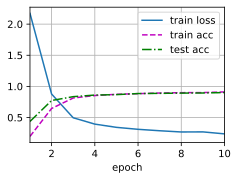

In [ ]:
%%time
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Примечание
Вообще обучать глубокие сети, в которых много-много слоев, доволно сложно. Не только технически, но и по сути, при прохождении информации по слоям градиент может затухать очень сильно, так, что параметры слоев перестают влиять на результат.

Банальный пример, пусть информация умножается в каждом слое на 0.9. пройдя пару слоев она уменьшится немного до 0.9*0.9=0.81, но если пройдет 100 слоев, то уменьшится до $0.9^{100}= 2.6*10^{-5}$, т.е. практически сойдет на ноль.

Вариант как помочь сети обучаться - обучать ее поблочно. Сначала сделать сеть с несколькими слоями, обучить ее. Потом добавить (вставить) еще блок, продолжить обучение всей сети и т.д. В сети Inception так и было сделано.


# Ссылки
Использованы и адаптированы материалы

https://d2l.ai/chapter_convolutional-modern/googlenet.html